In [1]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# COVID-19 + Pneumonia Chest X-Ray Classification using CNN with Google Drive Integration



# STEP 2: Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 3: Download Dataset to Google Drive
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p /content/drive/MyDrive/xray_data/

# STEP 4: Unzip Dataset in Google Drive
!!unzip -oq /content/drive/MyDrive/xray_data/covid19-radiography-database.zip -d /content/drive/MyDrive/xray_data/



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving kaggle.json to kaggle (5).json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
covid19-radiography-database.zip: Skipping, found more recently modified local copy (use --force to force download)


[]

In [2]:

# STEP 5: Define Dataset Path
base_dir = '/content/drive/MyDrive/xray_data/COVID-19_Radiography_Dataset'



In [ ]:
# STEP 6: Organize and Preprocess Data
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = 'dataset'
os.makedirs(dataset_dir, exist_ok=True)

categories = ['COVID', 'NORMAL', 'Viral Pneumonia']
for cat in categories:
    os.makedirs(os.path.join(dataset_dir, 'train', cat), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'val', cat), exist_ok=True)

def move_images(src_dir, dest_dir, category, split=0.8, max_images=1000):
    images = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))][:max_images]
    random.shuffle(images)
    split_point = int(len(images) * split)
    for i, image in enumerate(images):
        src = os.path.join(src_dir, image)
        dest_folder = os.path.join(dest_dir, 'train' if i < split_point else 'val', category)
        shutil.copy(src, dest_folder)

move_images(os.path.join(base_dir, 'COVID', 'images'), dataset_dir, 'COVID')
move_images(os.path.join(base_dir, 'Normal', 'images'), dataset_dir, 'NORMAL')
move_images(os.path.join(base_dir, 'Viral Pneumonia', 'images'), dataset_dir, 'Viral Pneumonia')



# STEP 7: Image Data Generators
data_gen = ImageDataGenerator(rescale=1./255)
train_gen = data_gen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
val_gen = data_gen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# STEP 8: Build CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# STEP 9: Train Model
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=10)

# STEP 10: Visualize Results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
model.save('/content/drive/MyDrive/xray_model.h5')


In [ ]:
# STEP 11: Predict on a New Image
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for img_name in uploaded.keys():
    img_path = img_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_labels = list(train_gen.class_indices.keys())

    print(f"\nPrediction: {class_labels[class_index]}")
    print(f"Confidence: {prediction[0][class_index]*100:.2f}%")

# STEP 12: Save Model in Recommended Format
model.save('covid_cnn_model.keras')


19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.33      0.42      0.37       200
         NORMAL       0.30      0.18      0.23       200
Viral Pneumonia       0.33      0.36      0.35       200

       accuracy                           0.32       600
      macro avg       0.32      0.32      0.31       600
   weighted avg       0.32      0.32      0.31       600



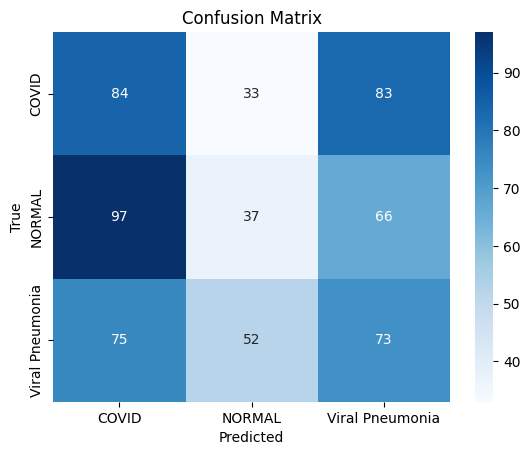

In [ ]:
# STEP 13: Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

class_labels = list(val_gen.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=list(val_gen.class_indices.values()), target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# STEP 14: Save Model to Google Drive
model.save('/content/drive/MyDrive/xray_data/covid_cnn_model.keras')

In [5]:
# STEP 15: Load Model from Google Drive
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/xray_data/covid_cnn_model.keras')
print("Model loaded successfully.")

# STEP 16: Predict on New Image Again (Optional)
uploaded = files.upload()

for img_name in uploaded.keys():
    img_path = img_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_labels = list(train_gen.class_indices.keys())

    print(f"\nPrediction: {class_labels[class_index]}")
    print(f"Confidence: {prediction[0][class_index]*100:.2f}%")


Model loaded successfully.


In [ ]:
!pip install opencv-python-headless


In [ ]:
# STEP 15: Gradio Web Interface for Chest X-Ray Prediction
!pip install -q gradio opencv-python-headless

import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved Keras model
model = load_model('/content/drive/MyDrive/xray_data/covid_cnn_model.keras')

# Define class names based on training
class_names = ['COVID', 'NORMAL', 'Viral Pneumonia']

# Image size expected by the model
IMG_WIDTH, IMG_HEIGHT = 224, 224

def predict_image(img):
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)[0]
    return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}

# Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy", label="Upload Chest X-ray"),
    outputs=gr.Label(num_top_classes=3),
    title="Chest X-ray Lung Disease Classifier",
    description="Classifies chest X-rays as COVID-19, Normal, or Viral Pneumonia. Upload an image to get prediction.",
    theme="default"
)

iface.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1fc260947f535fcf51.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [ ]:
for subset in ['train', 'val']:
    print(f"\n{subset.upper()} SET:")
    for cls in class_names:
        path = os.path.join(dataset_dir, subset, cls)
        print(f"{cls}: {len(os.listdir(path))} images")
